In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow import keras
from keras import layers, models

In [2]:
# Load the dataset
file_path = 'Merged_GNSS_and_SNR_HKLM.csv'
gnss_data = pd.read_csv(file_path)

In [3]:
# Define numerical and categorical columns
numerical_cols = ['Phase Residual (m)', 'Pseudorange Residual (m)', 
                  'STD of Pseudorange L1 (m)', 'STD of Pseudorange L2 (m)', 
                  'Elevation (¡Æ)', 'Azimuth (¡Æ)', 'SNR(dBHz)']

categorical_cols = ['PRN', 'Signal Type 1', 'Signal Type 2']


In [4]:
# Drop irrelevant or target-related columns from input features
X = gnss_data.drop(columns=['TIME', 'L1 MP(m)', 'C1 Code', 'C2 Code', 'DSI'])


In [5]:

# Target variable (multipath effect on L1 MP)
y = gnss_data['L1 MP(m)']

In [6]:
# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)])

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform both train and test sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert sparse matrices to dense
X_train_preprocessed = X_train_preprocessed.toarray()  # Convert sparse matrix to dense
X_test_preprocessed = X_test_preprocessed.toarray()    # Convert sparse matrix to dense


# CNN

In [8]:
# Define the CNN model architecture
model = models.Sequential()

# Input layer
model.add(layers.InputLayer(input_shape=(X_train_preprocessed.shape[1],)))

# Reshape layer: CNNs expect a 2D input, so we reshape the 1D feature vector
model.add(layers.Reshape((X_train_preprocessed.shape[1], 1)))

# Convolutional Layer 1
model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))

# Pooling Layer 1
model.add(layers.MaxPooling1D(pool_size=2))

# Convolutional Layer 2
model.add(layers.Conv1D(32, kernel_size=3, activation='relu'))

# Pooling Layer 2
model.add(layers.MaxPooling1D(pool_size=2))

# Flatten the output
model.add(layers.Flatten())

# Fully Connected Layer
model.add(layers.Dense(128, activation='relu'))

# Output Layer
model.add(layers.Dense(1, activation='linear'))  # Output is regression for multipath effect

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model summary
model.summary()

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 41, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 39, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 17, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,457 (154.13 KB)

 Trainable params: 39,457 (154.13 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = model.fit(X_train_preprocessed, y_train, epochs=10, batch_size=32, validation_data=(X_test_preprocessed, y_test))

Epoch 1/10
   1/8417 ━━━━━━━━━━━━━━━━━━━━ 11:54 85ms/step - loss: 0.0609 - mean_absolute_error: 0.1756

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8414/8417 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0427 - mean_absolute_error: 0.1154

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8417/8417 ━━━━━━━━━━━━━━━━━━━━ 105s 13ms/step - loss: 0.0427 - mean_absolute_error: 0.1154 - val_loss: 0.0370 - val_mean_absolute_error: 0.1069
Epoch 2/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 1524s 181ms/step - loss: 0.0386 - mean_absolute_error: 0.1074 - val_loss: 0.0359 - val_mean_absolute_error: 0.1055
Epoch 3/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 104s 12ms/step - loss: 0.0385 - mean_absolute_error: 0.1062 - val_loss: 0.0363 - val_mean_absolute_error: 0.1051
Epoch 4/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 108s 13ms/step - loss: 0.0388 - mean_absolute_error: 0.1066 - val_loss: 0.0358 - val_mean_absolute_error: 0.1042
Epoch 5/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 107s 13ms/step - loss: 0.0373 - mean_absolute_error: 0.1052 - val_loss: 0.0353 - val_mean_absolute_error: 0.1032
Epoch 6/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 108s 13ms/step - loss: 0.0369 - mean_absolute_error: 0.1044 - val_loss: 0.0355 - val_mean_absolute_error: 0.1029
Epoch 7/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 108s 13ms/step - loss: 0.0365 - mean_

In [10]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test_preprocessed, y_test)
print(f"Test Mean Absolute Error: {test_mae}")

  47/2105 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0367 - mean_absolute_error: 0.1056

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2105/2105 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0352 - mean_absolute_error: 0.1022
Test Mean Absolute Error: 0.1024230346083641


# FCNN

In [11]:
import tensorflow as tf
from keras import layers, models
from sklearn.metrics import mean_absolute_error

# Define the Fully Connected Neural Network (FCNN) model
fcnn_model = models.Sequential()

# Input layer
fcnn_model.add(layers.InputLayer(input_shape=(X_train_preprocessed.shape[1],)))

# Fully connected hidden layer 1
fcnn_model.add(layers.Dense(128, activation='relu'))

# Fully connected hidden layer 2
fcnn_model.add(layers.Dense(64, activation='relu'))

# Output layer (regression task for predicting L1 MP)
fcnn_model.add(layers.Dense(1, activation='linear'))

# Compile the model
fcnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model summary
fcnn_model.summary()

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,697 (53.50 KB)

 Trainable params: 13,697 (53.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the FCNN model
fcnn_history = fcnn_model.fit(X_train_preprocessed, y_train, epochs=10, batch_size=32, validation_data=(X_test_preprocessed, y_test))


Epoch 1/10
  22/8417 ━━━━━━━━━━━━━━━━━━━━ 1:04 8ms/step - loss: 0.0505 - mean_absolute_error: 0.1535

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8417/8417 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0406 - mean_absolute_error: 0.1111

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8417/8417 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step - loss: 0.0406 - mean_absolute_error: 0.1111 - val_loss: 0.0361 - val_mean_absolute_error: 0.1039
Epoch 2/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step - loss: 0.0389 - mean_absolute_error: 0.1056 - val_loss: 0.0356 - val_mean_absolute_error: 0.1035
Epoch 3/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 66s 8ms/step - loss: 0.0371 - mean_absolute_error: 0.1040 - val_loss: 0.0351 - val_mean_absolute_error: 0.1027
Epoch 4/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 66s 8ms/step - loss: 0.0373 - mean_absolute_error: 0.1039 - val_loss: 0.0352 - val_mean_absolute_error: 0.1030
Epoch 5/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step - loss: 0.0370 - mean_absolute_error: 0.1036 - val_loss: 0.0352 - val_mean_absolute_error: 0.1036
Epoch 6/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step - loss: 0.0373 - mean_absolute_error: 0.1035 - val_loss: 0.0351 - val_mean_absolute_error: 0.1031
Epoch 7/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 66s 8ms/step - loss: 0.0358 - mean_absolute_error: 

In [13]:
# Predict using the FCNN model
y_pred_fcnn = fcnn_model.predict(X_test_preprocessed)

# Calculate MAE for the FCNN
fcnn_mae = mean_absolute_error(y_test, y_pred_fcnn)
print(f"Fully Connected Neural Network MAE: {fcnn_mae}")

2105/2105 ━━━━━━━━━━━━━━━━━━━━ 1s 672us/step
Fully Connected Neural Network MAE: 0.10213301121303678


# Decision Tree

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

# Initialize the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)

In [15]:
# Train the Decision Tree model
dt_model.fit(X_train_preprocessed, y_train)

DecisionTreeRegressor(random_state=42)

In [16]:
# Predict using the Decision Tree model
y_pred_dt = dt_model.predict(X_test_preprocessed)

# Calculate MAE for Decision Tree
dt_mae = mean_absolute_error(y_test, y_pred_dt)
print(f"Decision Tree MAE: {dt_mae}")

Decision Tree MAE: 0.11107835798728687


# Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1)

rf_model.fit(X_train_preprocessed, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.4min


RandomForestRegressor(random_state=42, verbose=1)

In [19]:
from tqdm import tqdm

# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, warm_start=True)

# Initialize tqdm for progress monitoring
with tqdm(total=rf_model.n_estimators, desc="Training Random Forest") as pbar:
    for i in range(1, rf_model.n_estimators + 1):
        # Update the number of trees in the forest
        rf_model.n_estimators = i
        
        # Fit the model with the current number of trees
        rf_model.fit(X_train_preprocessed, y_train)
        
        # Update the progress bar
        pbar.update(1)


Training Random Forest: 100%|█████████████████| 100/100 [02:53<00:00,  1.73s/it]


In [20]:
# Predict using the Random Forest model
y_pred_rf = rf_model.predict(X_test_preprocessed)

# Calculate MAE for Random Forest
rf_mae = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MAE: {rf_mae}")

Random Forest MAE: 0.08710747086334604


# RNN

In [21]:
import tensorflow as tf
from keras import layers, models
from sklearn.metrics import mean_absolute_error

# Reshape the preprocessed data to fit the RNN input
# RNN expects input of shape (samples, timesteps, features), where timesteps = 1 in this case
X_train_rnn = X_train_preprocessed.reshape((X_train_preprocessed.shape[0], 1, X_train_preprocessed.shape[1]))
X_test_rnn = X_test_preprocessed.reshape((X_test_preprocessed.shape[0], 1, X_test_preprocessed.shape[1]))

# Define the Recurrent Neural Network (RNN) model
rnn_model = models.Sequential()

# Input layer with an LSTM (Long Short-Term Memory) layer
rnn_model.add(layers.LSTM(128, activation='tanh', input_shape=(1, X_train_preprocessed.shape[1])))

# Fully connected hidden layer
rnn_model.add(layers.Dense(64, activation='relu'))

# Output layer (regression task for predicting L1 MP)
rnn_model.add(layers.Dense(1, activation='linear'))

# Compile the model
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model summary
rnn_model.summary()

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        87,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,361 (372.50 KB)

 Trainable params: 95,361 (372.50 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the RNN model
rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_rnn, y_test))

Epoch 1/10
   6/8417 ━━━━━━━━━━━━━━━━━━━━ 1:37 12ms/step - loss: 0.0614 - mean_absolute_error: 0.1719

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8417/8417 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0413 - mean_absolute_error: 0.1106

/opt/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8417/8417 ━━━━━━━━━━━━━━━━━━━━ 98s 12ms/step - loss: 0.0413 - mean_absolute_error: 0.1106 - val_loss: 0.0364 - val_mean_absolute_error: 0.1046
Epoch 2/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 106s 13ms/step - loss: 0.0384 - mean_absolute_error: 0.1064 - val_loss: 0.0361 - val_mean_absolute_error: 0.1049
Epoch 3/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 109s 13ms/step - loss: 0.0380 - mean_absolute_error: 0.1052 - val_loss: 0.0363 - val_mean_absolute_error: 0.1047
Epoch 4/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 103s 12ms/step - loss: 0.0369 - mean_absolute_error: 0.1040 - val_loss: 0.0357 - val_mean_absolute_error: 0.1052
Epoch 5/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 102s 12ms/step - loss: 0.0369 - mean_absolute_error: 0.1040 - val_loss: 0.0353 - val_mean_absolute_error: 0.1037
Epoch 6/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 100s 12ms/step - loss: 0.0359 - mean_absolute_error: 0.1031 - val_loss: 0.0347 - val_mean_absolute_error: 0.1026
Epoch 7/10
8417/8417 ━━━━━━━━━━━━━━━━━━━━ 103s 12ms/step - loss: 0.0357 - mean_abs

In [23]:
# Predict using the RNN model
y_pred_rnn = rnn_model.predict(X_test_rnn)

# Calculate MAE for the RNN
rnn_mae = mean_absolute_error(y_test, y_pred_rnn)
print(f"Recurrent Neural Network MAE: {rnn_mae}")

2105/2105 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Recurrent Neural Network MAE: 0.10413853987553434


# SVM

In [24]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

# Initialize the Support Vector Machine regressor with RBF kernel
svm_model = SVR(kernel='rbf')  # RBF kernel is common for regression tasks

In [25]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the preprocessor on the training data and transform both train and test sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert sparse matrices to dense
X_train_preprocessed = X_train_preprocessed.toarray()  # Convert sparse matrix to dense
X_test_preprocessed = X_test_preprocessed.toarray()    # Convert sparse matrix to dense

# Subsample the data (e.g., use only 10% of the data)
X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train_preprocessed, y_train, test_size=0.9, random_state=42)

# Train the SVM model on the subsampled data
svm_model.fit(X_train_sampled, y_train_sampled)


SVR()

In [26]:

# Predict using the SVM model
y_pred_svm = svm_model.predict(X_test_preprocessed)

In [27]:
# Calculate the Mean Absolute Error (MAE) for SVM
svm_mae = mean_absolute_error(y_test, y_pred_svm)

print(f"Support Vector Machine MAE: {svm_mae}")

Support Vector Machine MAE: 0.10208629649844206


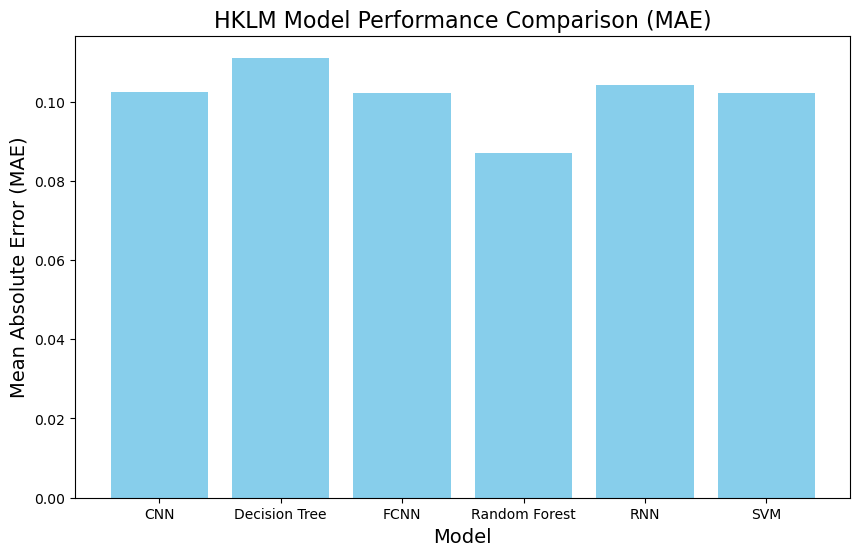

In [31]:
import matplotlib.pyplot as plt

# Replace these with the actual MAE values from your separate notebooks
cnn_mae = 0.1024230346083641  # From CNN_first.ipynb
dt_mae = 0.11107835798728687
fcnn_mae = 0.10213301121303678  # From FCNN.ipynb
random_forest_mae = 0.08710747086334604  # From RandomForest.ipynb
rnn_mae = 0.10413853987553434  # From RNN.ipynb
svm_mae = 0.10208629649844206  # From SVM.ipynb

# Dictionary of models and their MAE values
mae_values = {
    "CNN": cnn_mae,
    "Decision Tree": dt_mae,
    "FCNN": fcnn_mae,
    "Random Forest": random_forest_mae,
    "RNN": rnn_mae,
    "SVM": svm_mae
}

# Convert MAE values to lists
models = list(mae_values.keys())
mae_scores = list(mae_values.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, mae_scores, color='skyblue')

# Add title and labels
plt.title('HKLM Model Performance Comparison (MAE)', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)

# Display the bar chart
plt.show()
